# Create LDA Model of Army KSBs

#### Resources I used:
- <a href="https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28"> Using LDA Topic Models as a Classification Model Input </a> by Marc Kelechava. (<a href="https://github.com/marcmuon/nlp_yelp_review_unsupervised"> GitHub </a>)


## Imports

In [1]:
### Imports

# basic
import time
from pprint import pprint

# data science
import pandas as pd
import pickle

# NLP
import gensim
from gensim.models import CoherenceModel, LdaModel

# plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
### Import preprocesss_helpers module
import os
import sys

# add '/Users/richardkuzma/coding/analysis' to path
# where /utils holds module preprocess_helpers    
module_path = os.path.abspath(os.path.join('../..')) 
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.preprocess_helpers as ph

/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/richardkuzma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/richardkuzma/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Compute Perplexity
def compute_perplexity(corpus, model):
    """corpus is your bow corpus for instance"""
    """a measure of how good the model is. lower the better"""
    t0 = time.time()
    print('perplexing...')
    perplex = model.log_perplexity(corpus)
    print('{} seconds'.format(time.time()-t0))
    print('\nPerplexity: ', perplex)
    return perplex


def compute_coherence(model, texts, dictionary, coherence):
    """Takes model, texts, dictionary. Prints and outputs coherence score"""
    t0 = time.time()
    print('making coherence model...')
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
    print('{} seconds'.format(time.time()-t0))
    t0 = time.time()
    print('getting coherence...')
    coherence_lda = coherence_model_lda.get_coherence()
    print('{} seconds'.format(time.time()-t0))
    print('\nCoherence Score: ', coherence_lda)
    return coherence_lda

# Show graph
def coherence_graph(rg, coherence_values):
    plt.plot(rg, coherence_values, label = 'coherence')
#     plt.xlim(0, 22)
    plt.title("Coherence of LDA model")
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    print('plotted.')
    
def perplexity_graph(rg, perplex_values):
    plt.plot(rg, perplex_values, label = 'perplexity')
#     plt.xlim(0, 22)
    plt.title("Perplexity of LDA model")
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity score")
    plt.legend(("perplex_values"), loc='best')
    plt.show()
    print('plotted.')


# Print the coherence scores
def print_coherence_scores(rg, model_list, coherence_values):
    for num, cv, m in zip(rg, coherence_values, model_list):
        print("Num Topics = {} has Coherence Value of {} model specs: {}".format(num, round(cv, 4), m))


def visualize_lda(model, corpus, dictionary):
    """returns the pyLDAvis PreparedData given model, corpus, dictionary"""
    """Could pickle this to save it"""
    """pyLDAvis.save_html(vis, "filename") also works to export in html"""
    pyLDAvis.enable_notebook()
    t0 = time.time()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    print('{} seconds'.format(time.time()-t0))
    return vis


def compute_compare_c_v(dictionary, corpus, texts, rg=[2, 20, 6]):
    """
    Compute and compare c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplex_values = []
    model_list = []
    print('range entered: {}'.format(rg))
    for num_topics in rg:
        print('num_topics: {}'.format(num_topics))

        print('\nmaking model with {} topics...'.format(num_topics))

        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        print('model made: {}'.format(model))
        print('old model_list: {}'.format(model_list))
        model_list.append(model)
        print('appended. model_list now: {}'.format(model_list))

        print('\nperplexity...')
        p_score = compute_perplexity(corpus, model)
        perplex_values.append(p_score)
        print('appended perplexity')

        print('\ncoherence...')
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_score = compute_coherence(model, texts, dictionary, 'c_v') # my coherence model line
#         print('coherence: {}'.format(coherencemodel.get_coherence()))
#         coherence_values.append(coherencemodel.get_coherence())
        coherence_values.append(c_score)
        print('appended coherence')


    return model_list, coherence_values, perplex_values

## Load KSB list

In [4]:
### Load KSB from text file

path = '/Users/richardkuzma/coding/analysis/monster/data/raw/KSBs/'
filename = '00_all_ksb.txt'
text_file = open(path+filename, "r")
ksb_raw = text_file.read().split('\n')
ksb_raw.pop(0) # first element is called 'KSB', so remove it

print('Length KSB list: {}\n'.format(len(ksb_raw)))
print('First 10 elements: {}'.format(ksb_raw[:10]))

Length KSB list: 9900

First 10 elements: ['Account Auditor', 'Accountant', 'Auditor', 'Auditor-In-Charge', 'Certified Public Accountant', 'Cost Accountant', 'CPA', 'Field Auditor', 'Financial Accountant', 'Financial Auditor']


## Process text, make dictionary and BOW corpus

In [5]:
ksb_cleaned = ph.full_clean(ksb_raw)
ksb_dict = ph.make_dict(ksb_cleaned)
ksb_corpus = ph.make_bow(ksb_cleaned, ksb_dict)

lemmatizing...
lemmatization complete
8.365138292312622 seconds


In [6]:
### Choosing not to filter extremes because most KSBs probably aren't mentioned a lot...

## Choose best number of topics with HDP
HDP says 20...

In [7]:
from gensim.models import HdpModel
hdp = HdpModel(ksb_corpus, ksb_dict, chunksize=100)

In [8]:
len(hdp.print_topics())

20

## Choosing number of topics with perplexity / coherence

range entered: [10, 15, 20, 25, 30, 35, 40, 45, 50]
num_topics: 10

making model with 10 topics...
model made: LdaModel(num_terms=6107, num_topics=10, decay=0.5, chunksize=2000)
old model_list: []
appended. model_list now: [<gensim.models.ldamodel.LdaModel object at 0x7ffb3ec13690>]

perplexity...
perplexing...
2.7448558807373047 seconds

Perplexity:  -9.991713241201055
appended perplexity

coherence...
making coherence model...
0.0033981800079345703 seconds
getting coherence...
0.993779182434082 seconds

Coherence Score:  0.6298757311339226
appended coherence
num_topics: 15

making model with 15 topics...
model made: LdaModel(num_terms=6107, num_topics=15, decay=0.5, chunksize=2000)
old model_list: [<gensim.models.ldamodel.LdaModel object at 0x7ffb3ec13690>]
appended. model_list now: [<gensim.models.ldamodel.LdaModel object at 0x7ffb3ec13690>, <gensim.models.ldamodel.LdaModel object at 0x7ffb3e8634d0>]

perplexity...
perplexing...
2.344177722930908 seconds

Perplexity:  -14.2039593085

2.417383909225464 seconds

Perplexity:  -41.75230387563462
appended perplexity

coherence...
making coherence model...
0.004896879196166992 seconds
getting coherence...
3.9668118953704834 seconds

Coherence Score:  0.5423650804626778
appended coherence


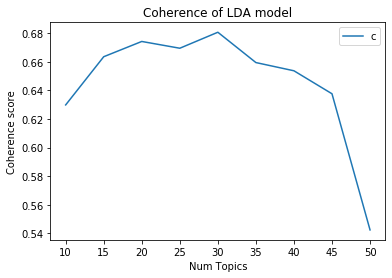

plotted.


NameError: name 'perlex_values' is not defined

In [9]:
rg = list(range(10, 51, 5))
model_list, coherence_values, perplex_values = compute_compare_c_v(dictionary=ksb_dict, corpus=ksb_corpus, texts=ksb_cleaned,  rg=rg)


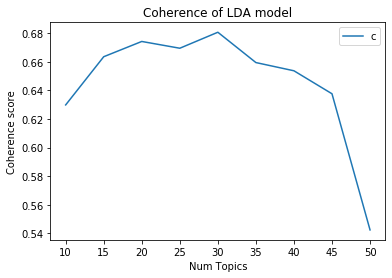

plotted.


In [10]:
coherence_graph(rg, coherence_values)

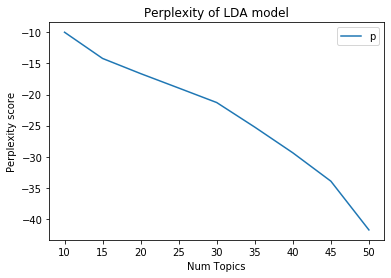

plotted.


In [11]:
perplexity_graph(rg, perplex_values)

In [13]:
rg2 = list(range(10, 101, 10))
model_list2, coherence_values2, perplex_values2 = compute_compare_c_v(dictionary=ksb_dict, corpus=ksb_corpus, texts=ksb_cleaned,  rg=rg2)

range entered: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
num_topics: 10

making model with 10 topics...
model made: LdaModel(num_terms=6107, num_topics=10, decay=0.5, chunksize=2000)
old model_list: []
appended. model_list now: [<gensim.models.ldamodel.LdaModel object at 0x7ffb283a2890>]

perplexity...
perplexing...
2.4380030632019043 seconds

Perplexity:  -10.005789877831685
appended perplexity

coherence...
making coherence model...
0.003681182861328125 seconds
getting coherence...
0.9307239055633545 seconds

Coherence Score:  0.6375072862866542
appended coherence
num_topics: 20

making model with 20 topics...
model made: LdaModel(num_terms=6107, num_topics=20, decay=0.5, chunksize=2000)
old model_list: [<gensim.models.ldamodel.LdaModel object at 0x7ffb283a2890>]
appended. model_list now: [<gensim.models.ldamodel.LdaModel object at 0x7ffb283a2890>, <gensim.models.ldamodel.LdaModel object at 0x7ffb28395290>]

perplexity...
perplexing...
2.216426134109497 seconds

Perplexity:  -16.6280

2.5033950805664062 seconds

Perplexity:  -128.32845697383112
appended perplexity

coherence...
making coherence model...
0.006754159927368164 seconds
getting coherence...
2.757359743118286 seconds

Coherence Score:  0.5866860008550888
appended coherence
num_topics: 100

making model with 100 topics...
model made: LdaModel(num_terms=6107, num_topics=100, decay=0.5, chunksize=2000)
old model_list: [<gensim.models.ldamodel.LdaModel object at 0x7ffb283a2890>, <gensim.models.ldamodel.LdaModel object at 0x7ffb28395290>, <gensim.models.ldamodel.LdaModel object at 0x7ffb293ad110>, <gensim.models.ldamodel.LdaModel object at 0x7ffb3ec14a50>, <gensim.models.ldamodel.LdaModel object at 0x7ffb3e8638d0>, <gensim.models.ldamodel.LdaModel object at 0x7ffb3ec3a050>, <gensim.models.ldamodel.LdaModel object at 0x7ffb3ec1cfd0>, <gensim.models.ldamodel.LdaModel object at 0x7ffb3ec76c10>, <gensim.models.ldamodel.LdaModel object at 0x7ffb3dc29990>]
appended. model_list now: [<gensim.models.ldamodel.LdaModel 

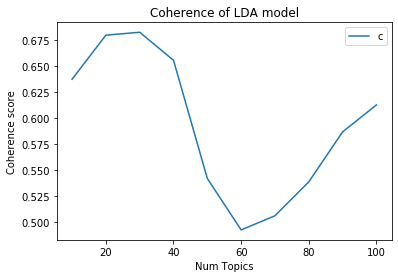

plotted.


In [14]:
coherence_graph(rg2, coherence_values2)

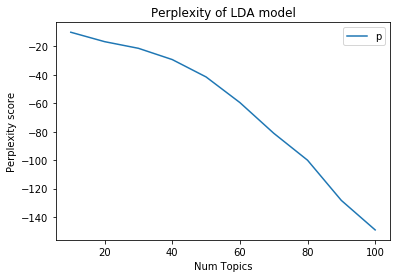

plotted.


In [15]:
perplexity_graph(rg2, perplex_values2)

In [16]:
# pick the best
print('Best coherence model')
best_cv = max(coherence_values, key=abs)
print(best_cv)
best_index = coherence_values.index(best_cv)
print(best_index)
best_model = model_list[best_index]
print(best_model)
best_num_topics = best_model.num_topics
print(best_num_topics)

Best coherence model
0.6807534740840404
4
LdaModel(num_terms=6107, num_topics=30, decay=0.5, chunksize=2000)
30


## LDA with 30 topics

In [17]:
pprint(best_model.print_topics())

[(13,
  '0.116*"electronics" + 0.063*"network" + 0.044*"designer" + 0.033*"support" '
  '+ 0.027*"transit_bus" + 0.026*"mechanical" + 0.025*"diagnostic" + '
  '0.021*"marine" + 0.020*"structural" + 0.020*"broadcast"'),
 (25,
  '0.100*"program" + 0.050*"oil" + 0.045*"investigator" + 0.036*"care" + '
  '0.031*"art" + 0.024*"pump" + 0.020*"specialist" + 0.019*"medium" + '
  '0.017*"railroad" + 0.015*"adobe"'),
 (24,
  '0.052*"part" + 0.049*"trainer" + 0.042*"personal" + 0.037*"agent" + '
  '0.024*"belt" + 0.024*"officer" + 0.021*"control" + 0.018*"city" + '
  '0.018*"buyer" + 0.018*"machinery"'),
 (26,
  '0.076*"advanced" + 0.068*"communication" + 0.048*"design" + '
  '0.035*"consultant" + 0.024*"group" + 0.020*"intelligence" + '
  '0.019*"technician" + 0.017*"operator" + 0.017*"chief" + '
  '0.016*"manufacturing"'),
 (3,
  '0.114*"clerk" + 0.052*"stamp" + 0.050*"treatment" + 0.048*"building" + '
  '0.031*"field" + 0.026*"critical" + 0.026*"hydraulic" + 0.017*"biomedical" + '
  '0.017*"co

## Convert KSB LDA Topics to vectors

### Load w2v KeyedVectors model trained on Google News
Note, KeyedVectors models are not full models you can retrain

In [18]:
goog = gensim.models.KeyedVectors.load_word2vec_format('/Users/richardkuzma/coding/analysis/utils/GoogleNews-vectors-negative300.bin.gz', binary=True, limit=500000)
print('loaded google w2v model of size 500,000 with dimension 300 vectors')


loaded google w2v model of size 500,000 with dimension 300 vectors


In [19]:
### use LDA probability distribution to find the center vector of each topic

pos_all = []
total_missed_words = 0

for i in range (0, best_model.num_topics): # for each LDA topic
    print('\n' + '-'*40 + 'Topic Number: {}'.format(i) + '-'*40 + '\n')
    missed_words = 0
    pos_topic = []
    for j in range(0, len(best_model.show_topic(i))): # for each words in a given topic
        try:
            # multiply w2v word vector by weight
            pos_topic.append(goog[best_model.show_topic(i)[j][0]]*float(best_model.show_topic(i)[j][1]))
            print('appended weighted vector for topic: {} and sub-word #{}: {} '.format(i, j, best_model.show_topic(i)[j][0]))
        except KeyError:
            print('Key error.......missed a word from topic: {}, number: {}, word: {}'.format(i,j,best_model.show_topic(i)[j][0]))
            missed_words +=1 
    
    total_missed_words += missed_words
    pos_all.append(pos_topic)
    print('\nappended pos_topic {} to pos_all'.format(i))
    print('Missed {} words'.format(missed_words))
    
print('Missed words in total: {}'.format(total_missed_words))
    

    
    
    
    


----------------------------------------Topic Number: 0----------------------------------------

appended weighted vector for topic: 0 and sub-word #0: helper 
appended weighted vector for topic: 0 and sub-word #1: board 
appended weighted vector for topic: 0 and sub-word #2: intelligence 
appended weighted vector for topic: 0 and sub-word #3: basic 
appended weighted vector for topic: 0 and sub-word #4: operator 
appended weighted vector for topic: 0 and sub-word #5: plant 
Key error.......missed a word from topic: 0, number: 6, word: cnc
appended weighted vector for topic: 0 and sub-word #7: community 
appended weighted vector for topic: 0 and sub-word #8: welder 
appended weighted vector for topic: 0 and sub-word #9: police 

appended pos_topic 0 to pos_all
Missed 1 words

----------------------------------------Topic Number: 1----------------------------------------

appended weighted vector for topic: 1 and sub-word #0: system 
appended weighted vector for topic: 1 and sub-word #

appended weighted vector for topic: 14 and sub-word #5: home 
appended weighted vector for topic: 14 and sub-word #6: manager 
appended weighted vector for topic: 14 and sub-word #7: well 
appended weighted vector for topic: 14 and sub-word #8: watch 
appended weighted vector for topic: 14 and sub-word #9: division 

appended pos_topic 14 to pos_all
Missed 0 words

----------------------------------------Topic Number: 15----------------------------------------

appended weighted vector for topic: 15 and sub-word #0: master 
appended weighted vector for topic: 15 and sub-word #1: management 
appended weighted vector for topic: 15 and sub-word #2: clinical 
appended weighted vector for topic: 15 and sub-word #3: medical 
appended weighted vector for topic: 15 and sub-word #4: emergency 
appended weighted vector for topic: 15 and sub-word #5: planning 
appended weighted vector for topic: 15 and sub-word #6: fitter 
appended weighted vector for topic: 15 and sub-word #7: family 
appended w

appended weighted vector for topic: 29 and sub-word #8: pediatric 
appended weighted vector for topic: 29 and sub-word #9: staff 

appended pos_topic 29 to pos_all
Missed 0 words
Missed words in total: 3


In [22]:
### use weighted word vectors to find the top 20 most similar words for each topic

similar_to_LDA_topics = []
for i in range(0, best_model.num_topics):
    similar_to_LDA_topics.append(goog.wv.most_similar(positive=pos_all[i], topn=15))

from pprint import pprint
for i in range(0, len(similar_to_LDA_topics)):
    print('Topic #{} most similar words'.format(i))
    pprint(similar_to_LDA_topics[i])
    print('\n\n' +'*'*40 + '\n\n')

Topic #0 most similar words
[('helper', 0.5801445245742798),
 ('mechanic', 0.5165066123008728),
 ('welder', 0.49296078085899353),
 ('technician', 0.48583725094795227),
 ('operator', 0.47923117876052856),
 ('electrician', 0.47810521721839905),
 ('worker', 0.46775108575820923),
 ('%_#F########_3v.jsn', 0.46732309460639954),
 ('supervisor', 0.4578937292098999),
 ('recounts_kidnapping', 0.4576948881149292),
 ('laborer', 0.45288997888565063),
 ('intelligence', 0.44993919134140015),
 ('carpenter', 0.4452344477176666),
 ('repairman', 0.44481486082077026),
 ('%_#F########_2v.jsn', 0.4397203326225281)]


****************************************


Topic #1 most similar words
[('system', 0.6053087115287781),
 ('aide', 0.6022248864173889),
 ('systems', 0.5076184868812561),
 ('%_#F########_3v.jsn', 0.48649877309799194),
 ('By_HARVEY_SIMPSON', 0.45074939727783203),
 ('%_#F########_2v.jsn', 0.45051437616348267),
 ('By_Dennis_Rockstroh', 0.4487171471118927),
 ('Letters_faxes', 0.44542473554611206),
 (

## Save 30-topic LDA model derived from 10,000 KSB aggregate list

In [24]:
path = '/Users/richardkuzma/coding/analysis/monster/models/'
filename = 'LDA_30_topics_10k_KSBs'

with open(path+filename, 'wb') as f:
    pickle.dump(best_model, f)

# Evaluation

Best model (by coherence):
- LdaModel(num_terms=6107, <b>num_topics=30</b>, decay=0.5, chunksize=2000)
- Coherence of <b>0.6807534740840404</b>
- Saved to '/Users/richardkuzma/coding/analysis/monster/models/LDA_30_topics_10k_KSBs'

Using a comprehensive list of 10,000 KSBs for LDA yields 20-30 topics that are too large. (e.g. 'supervisor', 'techincian', 'professional'. Will try to create separate LDA models for each